In [1]:
import re
import html
import os
from collections import Counter, defaultdict
import math
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import random
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import requests
from scipy import stats
from pathlib import Path
import pandas as pd
import csv
import json
import nltk
import ast
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize

Number of nodes in G: 472
Number of edges in G: 7100


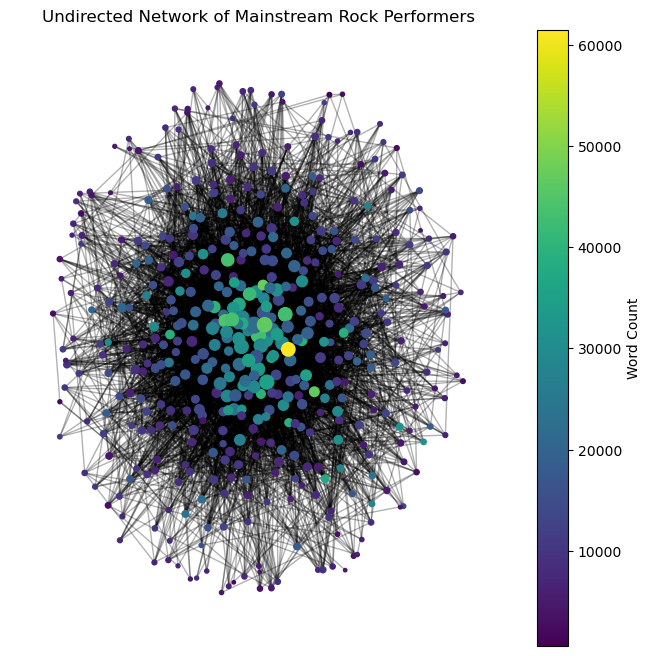

In [2]:
#  Loading the graph from Github as decribed in the exercise

# TODO TJEK at AllMusic ikke er med!!! (se degrees nedenfor))

# load graph from URL
url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Assignment2/Bands_graph.graphml"# Loading graph from a GraphML file from a URL
data = requests.get(url).text  
G = nx.parse_graphml(data)

# load graph from local file
# G = nx.read_graphml(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Noa/Bands_graph.graphml")

#### BASIC INFO
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of edges in G: {G.number_of_edges()}")

### VISULISATION
G_undirected = G.to_undirected()
# plot 
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G_undirected, seed=42, k = 0.8)  # positions for all 
#pos = nx.forceatlas2_layout(GCC_undirected, seed=42, strong_gravity=True)  # positions for all nodes

# node sizes based on degree
node_sizes = [5 + 1 * G_undirected.degree(n) for n in G_undirected.nodes()]

# node colors based on word count (content length)
node_colors = [G_undirected.nodes[n]['word_count'] for n in G_undirected.nodes()]
nodes = nx.draw_networkx_nodes(G_undirected, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)
plt.colorbar(nodes, label='Word Count')
plt.title('Undirected Network of Mainstream Rock Performers')
plt.axis('off')
plt.show()

----

# Part 2: Genres and communities and plotting
The questions below are based on Lecture 7, part 2.
- Write about genres and modularity
- Detect the communities, discuss the value of modularity in comparison to the genres.
- Plot the communities and comment on your results.
- Calculate the matrix $D$ and discuss your findings.
------

## Write about genres and modularity

Modularity is a measure that evaluates how well a network partitioning devides the network into communities. It does this by comparing the density of edges inside the communities vs the density between the communites. 
A high moduality means that the nodes of the communities are highly connected and there are few connections between the communities. A modularity of 1 means that there are only edges inside communities and no edges between communities, i.e. communities are perfectly seperated. A low modularity, around 0, means that there is no more community structure than there would be in a random network. Modularity can also be negative, and this means that the community structure is weaker than if the network had been random.

When we group/partition nodes based on genre, the modularity measure tells us something about if the bands that play the same genre music often will link to each other, or do they often link across genres. A high modularity would suggest that for instance pop-rock bands link primarily to other pop-rock bands.

## Detect the communities, discuss the value of modularity in comparison to the genres

As in part 1, we are using the network of mainstream rock performers.

To detect communities we firstly create a network of all the bands where an attribute on each node is all the genres listed in their wiki-infobox. To be able to compare and group the bands later we will add the genres in lowercase and normalize the genre names, e.g. "R&B"->"rhythm and blues" etc. We have also chosen to remove the qualifiers of genres stating if the genre is "(early)" or "(later)" to make fewer categories and see stronger patterns.

In the following code we have created the functions to detect the genres inside the infoboxes of the plain wiki-text of the bands, and a function to clean the found genres. This is made using an LLM, as we did in the exercises from week 7.

In [3]:
def extract_genres_from_wikitext(wikitext_content):
    """
    Extract a cleaned, normalized list of genres from Wikipedia-like wikitext.
    - Removes refs, citation templates, wrapper templates, HTML, and wiki links.
    - Strips all parenthetical qualifiers (e.g., '(early)', '(late)') and broken tails.
    - Lowercases all genres.
    - Normalizes common variants (rock & roll, r&b, hip-hop, post punk, synth pop, etc.).
    - Drops obvious template/config noise.
    - Deduplicates while preserving order.
    """
    # Isolate the 'genre =' field in the infobox
    m = re.search(
        r'\|\s*genre\s*=\s*(.*?)(?=\n\s*\||\n}})',
        wikitext_content,
        flags=re.DOTALL | re.IGNORECASE
    )
    if not m:
        return []
    g = m.group(1)

    # Decode HTML entities (&lt;ref&gt; -> <ref>, &amp; -> &, etc.)
    g = html.unescape(g)

    # Remove HTML comments
    g = re.sub(r'<!--.*?-->', '', g, flags=re.DOTALL)

    # Remove references: self-closing BEFORE paired to avoid cross-line capture
    g = re.sub(r'<ref[^>]*/>', '', g, flags=re.DOTALL | re.IGNORECASE)                      # <ref .../>
    g = re.sub(r'<ref(?:(?!/>)[^>])*?>.*?</ref>', '', g, flags=re.DOTALL | re.IGNORECASE)   # <ref ...>...</ref>

    # Remove citation/footnote templates entirely
    g = re.sub(r'\{\{\s*cite[^{}]*\}\}', '', g, flags=re.IGNORECASE)                        # {{cite web|...}}
    g = re.sub(r'\{\{\s*harv-?nb?[^{}]*\}\}', '', g, flags=re.IGNORECASE)                   # {{harvnb}}, {{harv-nb}}
    g = re.sub(r'\{\{\s*(sfn|sfnb|efn|refn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)         # {{sfn}}, {{refn}}, etc.
    g = re.sub(r'\{\{\s*(citation needed|cn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)        # {{citation needed}}, {{cn}}

    # Drop wrapper templates but keep their inner content
    g = re.sub(r'\{\{\s*(flatlist|hlist|nowrap|plainlist|ubl|unbulleted list)\s*\|?', '',
               g, flags=re.IGNORECASE)

    # Remove remaining braces and HTML tags like <small>, <i>, etc.
    g = g.replace('{{', '').replace('}}', '')
    g = re.sub(r'<[^>]+>', '', g)

    # Replace wiki links [[A|B]] -> B; [[A]] -> A
    g = re.sub(r'\[\[(?:[^|\]]+\|)?([^\]]+)\]\]', r'\1', g)

    # Normalize whitespace (incl. NBSP) and bullets
    g = g.replace('\xa0', ' ')
    g = g.replace('*', ' ')

    # Split on common delimiters
    parts = re.split(r'[\n,;•·]+|\s*\|\s*', g)

    # --- Normalization helpers ---

    # Canonical mapping for near-duplicates and synonyms (all keys/values lowercase)
    CANON_MAP = {
        # rock and roll family
        "rock & roll": "rock and roll",
        "rock and roll": "rock and roll",
        "rock 'n' roll": "rock and roll",
        "rock ’n’ roll": "rock and roll",
        "rock `n` roll": "rock and roll",

        # r&b / rhythm & blues
        "r&b": "rhythm and blues",
        "r & b": "rhythm and blues",
        "rhythm & blues": "rhythm and blues",

        # hip hop
        "hip-hop": "hip hop",
        "hip–hop": "hip hop",

        # hyphen/space variants
        "post punk": "post-punk",
        "synth pop": "synth-pop",
        "dance rock": "dance-rock",
        "blue eyed soul": "blue-eyed soul",

        # AOR
        "aor": "album-oriented rock",
    }

    # Regexes for pattern families
    ROCKNROLL_RX = re.compile(r"rock\s*(?:&|and|['`´’]\s*n['`´’])\s*roll")
    HIPHOP_RX    = re.compile(r"hip\s*[-–]?\s*hop")
    RAND_B_RX    = re.compile(r"(?:^|\b)r\s*&\s*b(?:\b|$)|rhythm\s*&\s*blues")

    # Token acceptability: letters (incl. accents), numbers, space, hyphen, apostrophes/quotes, ampersand, dots
    ALLOWED_RX   = re.compile(r"^[0-9A-Za-zÀ-ÖØ-öø-ÿ\s\-\&'`´’\.]+$")

    # Substrings indicating template/config noise to drop
    DROP_SUBSTRS = [
        'citation', 'cite', 'access-date', 'archive-url', 'archive-date',
        'publisher=', 'website=', 'title=', 'url=', 'first=', 'last=',
        'class=', 'nowrap', 'italic', 'lang', 'script=', 'format='
    ]

    def normalize_label(t: str) -> str:
        # Trim punctuation
        t = t.strip()
        t = re.sub(r'^[\W_]+|[\W_]+$', '', t)
        if not t:
            return ''

        # Drop obvious noise
        lo = t.lower()
        if any(s in lo for s in DROP_SUBSTRS):
            return ''

        # Remove any parenthetical parts, even if multiple (e.g., "(early)", "(later)")
        t = re.sub(r'\s*\([^)]*\)', '', t).strip()
        # If an unmatched '(' tail remains, drop that too (e.g., "funk metal (early")
        t = re.sub(r'\s*\([^)]*$', '', t).strip()

        # Lowercase
        t = t.lower()

        # Normalize rock and roll forms
        if ROCKNROLL_RX.search(t):
            t = ROCKNROLL_RX.sub('rock and roll', t)

        # Normalize hip hop forms
        if HIPHOP_RX.search(t):
            t = HIPHOP_RX.sub('hip hop', t)

        # Normalize r&b / rhythm & blues
        if RAND_B_RX.search(t):
            t = 'rhythm and blues'

        # Apply canonical map (covers aor, synth-pop, post-punk, blue-eyed soul, dance-rock, etc.)
        t = CANON_MAP.get(t, t)

        # Reject invalid tokens (after normalization)
        if not ALLOWED_RX.match(t):
            return ''

        # Collapse repeated spaces and strip stray punctuation
        t = re.sub(r'\s{2,}', ' ', t).strip('. ').strip()

        return t

    cleaned = [normalize_label(p) for p in parts]
    cleaned = [c for c in cleaned if c]

    # Deduplicate while preserving order (already lowercase)
    out, seen = [], set()
    for x in cleaned:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

In the following we loop through all wiki-texts of bands in a directory and make a dictionary of the bands and their genres.

In [4]:

# Directory where all band data files are located
data_directory = "Bands"
band_genres = {}

# if data_directory folder not found load from txt file
if not os.path.exists(data_directory):
    url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Assignment2/band_genres.txt"
    data = requests.get(url).text
    # Process the downloaded data
    for line in data.strip().split('\n'):
        if ':' in line:
            band_name, genres_str = line.strip().split(":", 1)
            # The genres are comma-separated, but some might be empty strings if the line ends with a comma
            genres = [genre.strip() for genre in genres_str.split(",") if genre.strip()]
            band_genres[band_name] = genres
else:
    # Iterate over all files in the specified directory
    for filename in os.listdir(data_directory):
        file_path = os.path.join(data_directory, filename)
        band_name = os.path.splitext(filename)[0] # Get band name from filename

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                genres = extract_genres_from_wikitext(content)
                band_genres[band_name] = genres
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# order the band list alphabetically
band_genres = dict(sorted(band_genres.items()))


For the TA's we have left this code above, such that it is possible to see how we constructed the graph with the genres as attributes. But the bands are actually loaded from the txt file, which is created from the dictionary above

The top 15 genres are listed below in a histogram

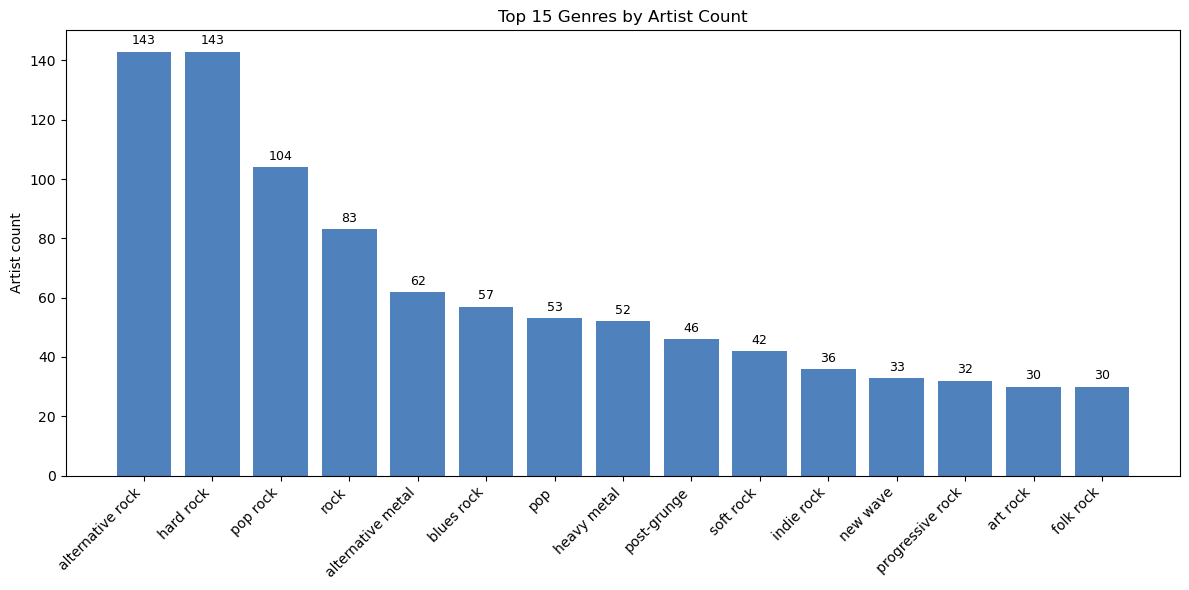

In [5]:
# Artists with at least one genre
artists_with_genres = {artist: genres for artist, genres in band_genres.items() if genres}

# Top-15 genres histogram (by artist counts)

# Count per genre (ensures an artist counted only once per genre even if duplicates slipped in)
genre_to_artists = defaultdict(set)
for artist, genres in artists_with_genres.items():
    for g in set(genres):  # set() to be safe against accidental duplicates
        genre_to_artists[g].add(artist)

genre_counts = Counter({g: len(artist_set) for g, artist_set in genre_to_artists.items()})

top_n = 15
top15 = genre_counts.most_common(top_n)

# Plot
if top15:
    genres_plot, counts_plot = zip(*top15)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(genres_plot)), counts_plot, color="#4F81BD")
    plt.xticks(range(len(genres_plot)), genres_plot, rotation=45, ha='right')
    plt.ylabel("Artist count")
    plt.title(f"Top {top_n} Genres by Artist Count")
    # Add value labels on bars
    for bar, val in zip(bars, counts_plot):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts_plot)*0.01,
                 str(val), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No genres to plot for histogram (top15 is empty).")

Above we have on the y-axis the frequency/the number of bands that have the genre on the x-axis as one of their listed genres in their wiki-infobox. It is worth to note that a lot of these genres are rock sub-genres, but we have chosen not to join these genres into one and keep them seperated. 

We see that the band/performer pool is dominated by the alternative rock and hard rock genre. Pop rock and rock are also heavily represented. Metal is also represented in the histogram with subgenres alternative and heavy, having 62 and 52 counts respectively. 


We would now like to explore how community-like the communities are, if we consider the genres to be community labels. We use the modularity measure to do this. We firstly create the undirected links between the bands and we only keep the bands that actually have infoboxes and have a genre list in their wiki-text. The links between bands are added using the graph constructed for Assignment 1 (the one also used in part 1).

Removed 15 nodes with no links. The graph now has 457 nodes and 5569 edges.


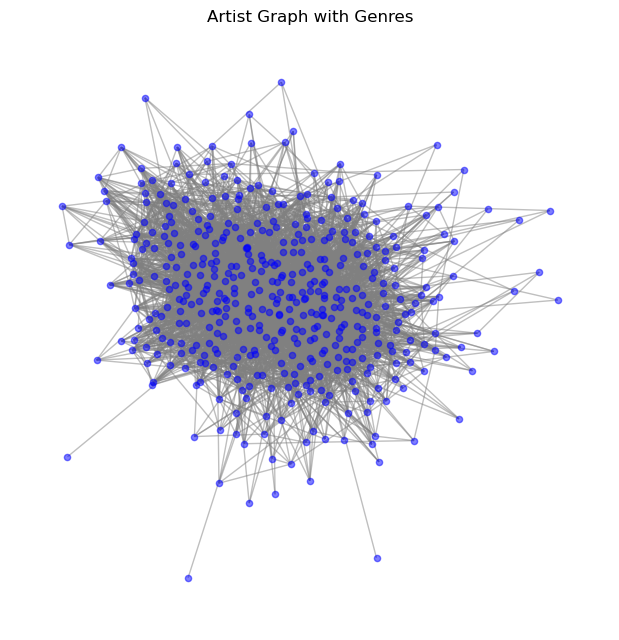

In [6]:
# Create an empty graph
G_artists = nx.Graph()

# Add nodes to the graph from the artists_with_genres
# The keys of the dictionary are the artist names (nodes)
# The values are the lists of genres (attributes)
for artist, genres in artists_with_genres.items():
    G_artists.add_node(artist, genres=genres)

# Load the original links graph from Assignment 1 (also used in part 1 of this assignment)
G_links = G.copy()
# Adding edges to G_artists based on G_links
G = G_artists.copy()

for u, v in G_links.edges():
    if G.has_node(u) and G.has_node(v):
        G.add_edge(u, v)

# NOTE: G is now our final graph with genres as node attributes and the links are the original links from Assignment 1 and all nodes are removed that has no info-box

# Remove nodes with no links
nodes_to_remove = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(nodes_to_remove)
print(f"Removed {len(nodes_to_remove)} nodes with no links. The graph now has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.5)
plt.title("Artist Graph with Genres")
plt.show()


Above we have chosen to remove the bands/nodes that doesn't have any links, as these could contribute to the modularity measure being misleading. This is because isolated nodes have no edges, so they do not contribute to community structure. These nodes will likely be assigned to their own “community” by most algorithms. When we later try to create louvain communities this will most likely create many tiny communities, lowering modularity and making the network look fragmented.

To create the partitioning we choose the first genre in the list as the label for the node/band. This makes each community be the group of nodes that share the same first genre in their list of genres. We then calculate the modularity according to Eq. 9.12 in the book.

In [7]:
# Each node is assigned to the community of its first listed genre
communities_by_genre = defaultdict(list)
for node, data in G.nodes(data=True):
    genres = data.get('genres')
    if genres:
        first_genre = genres[0]
        communities_by_genre[first_genre].append(node)

# a list of sets (the communities).
partition = [set(nodes) for nodes in communities_by_genre.values()]

def modularity(G, partition):
    """
    Compute modularity using Eq. 9.12:
    """
    L = G.number_of_edges()  # total edges
    degrees = dict(G.degree())

    M = 0.0
    for community in partition:
        # Internal edges in community
        L_c = G.subgraph(community).number_of_edges()
        # Sum of degrees in community
        k_c = sum(degrees[node] for node in community)
        M += (L_c / L) - (k_c / (2 * L)) ** 2

    return M

# Calculate and report the modularity 
mod = modularity(G, partition)
print(f"\nCreated a partition with {len(partition)} communities based on the first genre.")
print(f"Modularity: {mod:.4f}")


Created a partition with 77 communities based on the first genre.
Modularity: 0.0944


In [8]:
random.seed(42)

communities_by_genre_rand = defaultdict(set)

for node, data in G.nodes(data=True):
    genres = data.get('genres') or []
    if not genres:
        continue
    chosen = random.choice(genres)  # uniform random choice among available genres
    communities_by_genre_rand[chosen].add(node)

# Remove empty sets and return as list of sets
partition_rand = [nodes for nodes in communities_by_genre_rand.values() if nodes]

M_rand = modularity(G, partition_rand)
print(f"Random-genre partition modularity: {M_rand:.4f}")

Random-genre partition modularity: 0.0365


## Plot the communities and comment on your results

We will now use the Louvain-algorithm to find communities for the network.

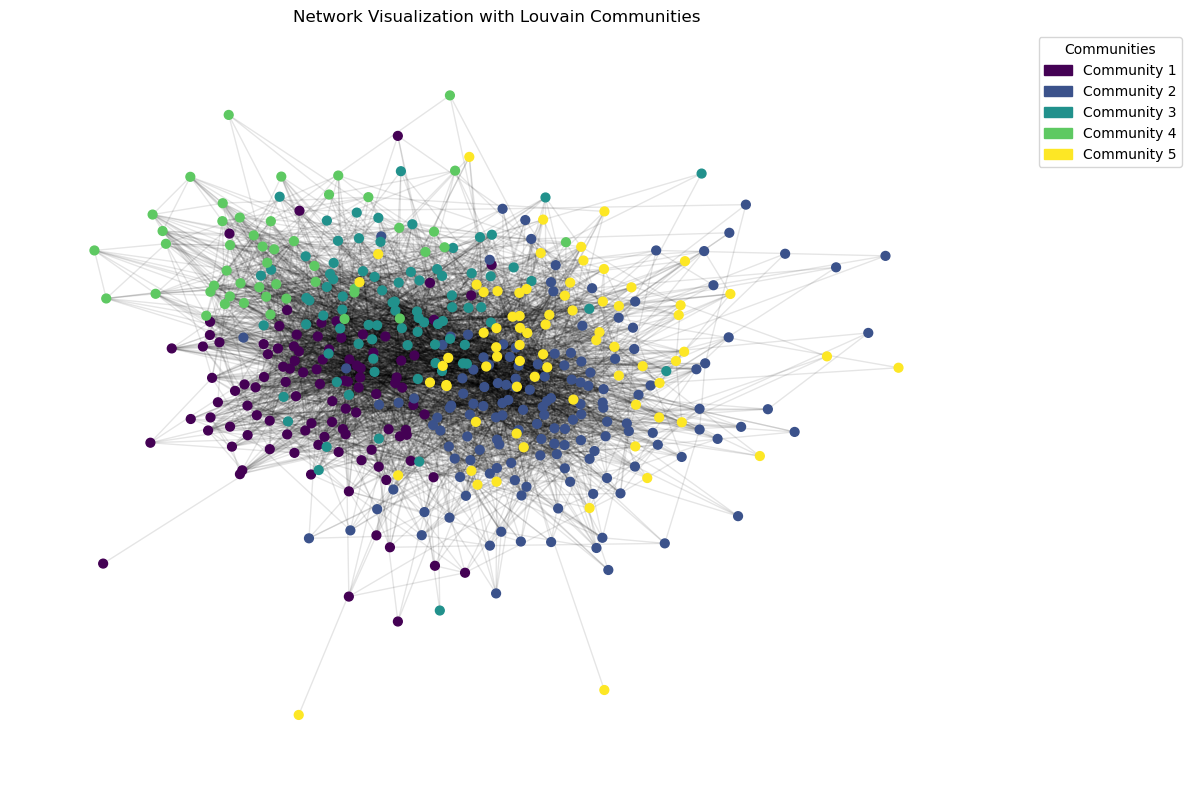


Louvain method found 5 communities with a modularity of 0.3390.


In [9]:
# using networkx louvain_communities to find communities
louvain_communities = list(nx.community.louvain_communities(G, seed=11))
louvain_modularity = nx.community.modularity(G, louvain_communities)

# visualize the network using the Force Atlas algorithm with communities colored differently
# using louvain_communities
partition = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        partition[node] = i


# Set the size of the plot
plt.figure(figsize=(12, 8))
# Compute the layout using spring layout (Force Atlas-like)
pos = nx.spring_layout(G, seed=42)
# Draw nodes with colors based on their community
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.1)
# We will create custom legend handles because networkx doesn't do it automatically
legend_handles = []
for i in range(len(louvain_communities)):
    legend_handles.append(Patch(color=cmap(i), label=f'Community {i+1}'))

plt.legend(handles=legend_handles, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Network Visualization with Louvain Communities")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nLouvain method found {len(louvain_communities)} communities with a modularity of {louvain_modularity:.4f}.")

## Calculate the matrix $D$ and discuss your findings

We will now compare the communities found by the Louvain algorithm with the music genres by creating a matrix D with dimension (GxC), where G is the 5 most common genres and C is the 5 most common communities. We set entry D(i,j) to be the number of nodes that genre i has in common with community j.

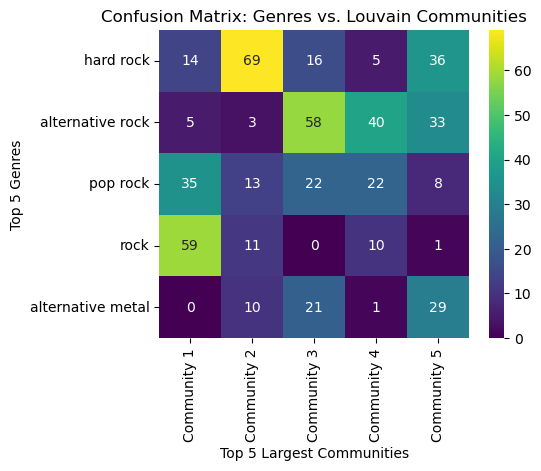

In [10]:
# Identify the 5 most common genres - Using all genres associated with each node
all_genres_list = []
for node, data in G.nodes(data=True):
    if 'genres' in data:
        all_genres_list.extend(data['genres'])

genre_counts = Counter(all_genres_list)
top_5_genres = [genre for genre, count in genre_counts.most_common(5)]
top_5_genres_set = set(top_5_genres)


# Identify the 5 largest communities
louvain_communities.sort(key=len, reverse=True)
top_5_communities = louvain_communities[:5]

# Create a set of all nodes that are in one of the top 5 communities
nodes_in_top_communities = set()
for community in top_5_communities:
    nodes_in_top_communities.update(community)


genre_to_idx = {genre: i for i, genre in enumerate(top_5_genres)}
# Map each node to its community index (1-5)
node_to_community_idx = {}
for i, community in enumerate(top_5_communities):
    for node in community:
        node_to_community_idx[node] = i


# Confusion matrix
confusion_matrix = np.zeros((5, 5), dtype=int)

# Iterate through all nodes in the graph that are in the top communities
for node in nodes_in_top_communities:
    # Check if the node has genre data
    if 'genres' in G.nodes[node]:
        node_genres = G.nodes[node]['genres']
        
        # Find which of the top 5 genres this node has
        relevant_genres = top_5_genres_set.intersection(node_genres)
        
        # If the node has at least one of the top 5 genre
        if relevant_genres:
            community_idx = node_to_community_idx[node]
            
            for genre in relevant_genres:
                genre_idx = genre_to_idx[genre]
                confusion_matrix[genre_idx, community_idx] += 1


# Visualize
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[f'Community {i+1}' for i in range(5)],
            yticklabels=top_5_genres)
plt.title('Confusion Matrix: Genres vs. Louvain Communities')
plt.ylabel(f'Top {5} Genres')
plt.xlabel(f'Top {5} Largest Communities')
plt.show()

In [ ]:
import os
import re
from collections import Counter, defaultdict
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS 

def clean_wikitext(text):
    text = html.unescape(text)
    
    # Remove URLs and tags
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\{\{.*?\}\}', ' ', text)
    text = re.sub(r'<ref.*?>.*?</ref>', ' ', text)
    text = re.sub(r'\[\[File:.*?\]\]', ' ', text)

    # Remove table junk
    text = re.sub(r'\b(bar|color|width|align|text|scope|center|style|bgcolor|rowspan|colspan)\b', ' ', text)

    # Handle wiki links, keeping the inner text
    text = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', text)
    
    # Remove non-alphabetic characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove capitalized words (likely proper names)
    text = re.sub(r'\b[A-Z][a-z]+\b', ' ', text)

    return text.lower()

# Create TF lists for each of the top 5 genres
# Assumes `top15` and `artists_with_genres` are available from previous cells.
top_5_genre_names = [genre for genre, count in top15[:5]]

# Directory where artist pages are stored
BANDS_TEXT_DIRECTORY = "Bands" #TODO

TF_lists={}

lemmatizer = WordNetLemmatizer()

# Aggregate text for each of the top 5 genres
genre_texts = defaultdict(str)

# Create a reverse map from genre to list of artists
# !! we add each artist to all their genre lists (if they have multiple genres)
genre_to_artists_map = defaultdict(list)
for artist, genres in artists_with_genres.items():
    for genre in genres:
        if genre in top_5_genre_names:
            genre_to_artists_map[genre].append(artist)

# Read files and append text
for genre, artists in genre_to_artists_map.items():
    for artist in artists:
        file_path = os.path.join(data_directory, f"{artist}.txt")
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    genre_texts[genre] += f.read() + "\n"
            except Exception as e:
                print(f"  Could not read file {file_path}: {e}")

# Process each genre document to create TF lists
for genre, text in genre_texts.items():

    # Use the cleaning function. (setting to lower case)
    text = clean_wikitext(text)
    
    # Tokenize and remove punctuation (find sequences of word characters)
    tokens = re.findall(r'\b[a-z]+\b', text)
    
    # Lemmatize words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Count word frequencies
    word_counts = Counter(lemmatized_tokens)
    
    # Filter out rare words (appearing less than 5 times) and any stop words
    # Define a set of stop words and wiki-related noise to exclude
    stop_words = {
        'a', 'accessed', 'access', 'align', 'album', 'albums', 'an', 'and', 'archive',
        'archived', 'article', 'at', 'background', 'band', 'bands', 'bar', 'border',
        'by', 'category', 'center', 'chart', 'charts', 'cite', 'col', 'color', 'com',
        'date', 'external', 'file', 'first', 'font', 'for', 'from', 'group', 'he',
        'his', 'http', 'https', 'id', 'image', 'in', 'is', 'isbn', 'it', 'jpg',
        'label', 'last', 'links', 'lyrics', 'main', 'music', 'name', 'new', 'notes',
        'of', 'on', 'org', 'original', 'p', 'page', 'png', 'publisher', 'ref',
        'references', 'released', 'retrieved', 'row', 's', 'sfn', 'scope', 'song',
        'songs', 'svg', 'table', 'template', 'that', 'the', 'their',
        'they', 'till', 'time', 'title', 'to', 'url', 'via', 'wa', 'web', 'website',
        'width', 'with', 'work', 'www', 'year', 'cc','ska', 'rn', 'pp'
    }
    stop_words = ENGLISH_STOP_WORDS.union(stop_words) # Combine the lists

    frequent_word_counts = {word: count for word, count in word_counts.items() if count >= 5 and word not in stop_words}

    # Sort words by frequency in descending order
    sorted_word_counts = sorted(frequent_word_counts.items(), key=lambda item: item[1], reverse=True)
    
    # Store TF list in dictionary
    TF_lists[genre] = sorted_word_counts

-----
# Part 3:TEST

-----

In [ ]:

import html
from pathlib import Path
import nltk
nltk.download('wordnet', quiet=True)
import os
import re
import json
from collections import Counter, defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS 
from pathlib import Path

# Directory where artist pages are stored
BANDS_TEXT_DIRECTORY = Path("Bands")  # was a string; needs to be a Path

def clean_wikitext(text):
    text = html.unescape(text)

    # Remove URLs and tags
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\{\{.*?\}\}', ' ', text)
    text = re.sub(r'<ref.*?>.*?</ref>', ' ', text)
    text = re.sub(r'\[\[File:.*?\]\]', ' ', text)

    # Keep display text in wiki links
    text = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', text)

    # Remove table junk
    text = re.sub(r'\b(bar|color|width|align|text|scope|center|style|bgcolor|rowspan|colspan)\b', ' ', text)

    # 🔹 Remove capitalized words (likely proper names)
    text = re.sub(r'\b[A-Z][a-z]+\b', ' ', text)

    # Clean up
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()
    #text = remove_proper_nouns(text)
    return text


def get_band_text(band_name):
    """
    Retrieves and cleans the wikitext for a given band from a local file.
    """
    file_path = BANDS_TEXT_DIRECTORY / f"{band_name}.txt"
    if not file_path.exists():
        return ""
    try:
        raw_content = file_path.read_text(encoding='utf-8')
        # Try JSON format first
        try:
            data = json.loads(raw_content)
            page_id = next(iter(data["query"]["pages"]))
            wikitext = data["query"]["pages"][page_id]["revisions"][0]["slots"]["main"]["*"]
            return clean_wikitext(wikitext)
        except (json.JSONDecodeError, KeyError, StopIteration, TypeError):
            # Fallback: treat as raw wikitext/text
            return clean_wikitext(raw_content)
    except Exception as e:
        print(f"Could not process file for {band_name}: {e}")
        return ""

# Create TF lists for each of the top 5 genres
top_5_genre_names = [genre for genre, count in top15[:5]]

TF_lists = {}
lemmatizer = WordNetLemmatizer()

# Aggregate text for each of the top 5 genres
genre_texts = defaultdict(str)

# Map from genre to artists (add each artist to all their genres)
genre_to_artists_map = defaultdict(list)
for artist, genres in artists_with_genres.items():
    for genre in genres:
        if genre in top_5_genre_names:
            genre_to_artists_map[genre].append(artist)

# Read files and append text
for genre, artists in genre_to_artists_map.items():
    genre_texts[genre] = " ".join(get_band_text(artist) for artist in artists)

# Process each genre document to create TF lists
for genre, text in genre_texts.items():
    text = clean_wikitext(text)

    tokens = re.findall(r'\b[a-z]+\b', text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    word_counts = Counter(lemmatized_tokens)

    # Stopwords
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stop_words = {
        'a', 'accessed', 'access', 'align', 'album', 'albums', 'an', 'and', 'archive',
        'archived', 'article', 'at', 'background', 'band', 'bands', 'bar', 'border',
        'by', 'category', 'center', 'chart', 'charts', 'cite', 'col', 'color', 'com',
        'date', 'external', 'file', 'first', 'font', 'for', 'from', 'group', 'he',
        'his', 'http', 'https', 'id', 'image', 'in', 'is', 'isbn', 'it', 'jpg',
        'label', 'last', 'links', 'lyrics', 'main', 'music', 'name', 'new', 'notes',
        'of', 'on', 'org', 'original', 'p', 'page', 'png', 'publisher', 'ref',
        'references', 'released', 'retrieved', 'row', 's', 'sfn', 'scope', 'song',
        'songs', 'svg', 'table', 'template', 'that', 'the', 'their',
        'they', 'till', 'time', 'title', 'to', 'url', 'via', 'wa', 'web', 'website',
        'width', 'with', 'work', 'www', 'year', 'cc', 'ska', 'rn', 'pp'
    }
    stop_words = ENGLISH_STOP_WORDS.union(stop_words)

    frequent_word_counts = {
        word: count for word, count in word_counts.items()
        if count >= 5 and word not in stop_words
    }

    TF_lists[genre] = sorted(frequent_word_counts.items(), key=lambda item: item[1], reverse=True)


im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im in jason
im i

Now that we have our TF lists for the top 5 genres, we will calculate the IDF and afterwards the TF-IDF.

In [21]:
### Compute IDF
def compute_idf(df, N, method="smooth"):
    if method == "standard":
        return math.log10(N / df)
    elif method == "smooth":
        return math.log10(N / (1 + df)) + 1
    elif method == "prob":
        return math.log10((N - df) / df)

# Calculate frequency for each word across genres/documents
document_frequency = defaultdict(int)
for _, tf_list in TF_lists.items():
    for word, _ in tf_list:
        document_frequency[word] += 1

num_documents = len(TF_lists)
idf = {}
for word, df in document_frequency.items():
    idf[word] = compute_idf(df, num_documents, method="standard")


### Compute TF-IDF scores for each word in each genre
genre_tfidf = {}
for genre, tf_list in TF_lists.items():
    tfidf_scores = {}
    for word, tf in tf_list:
        tfidf_scores[word] = tf * idf.get(word, 0)
    genre_tfidf[genre] = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)



We can now visualize the difference between the TF and TF-IDF in wordclouds. We have chosen to display the top 50 words to make it possible to distinguish between the words but still get a large representation. 

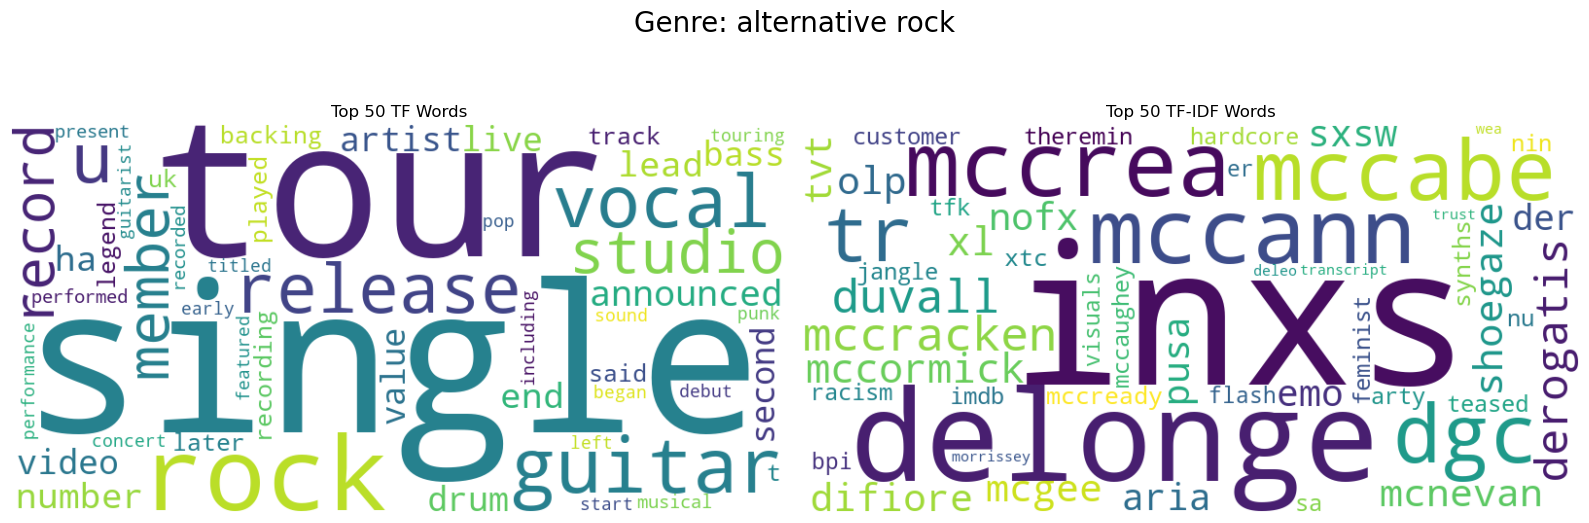

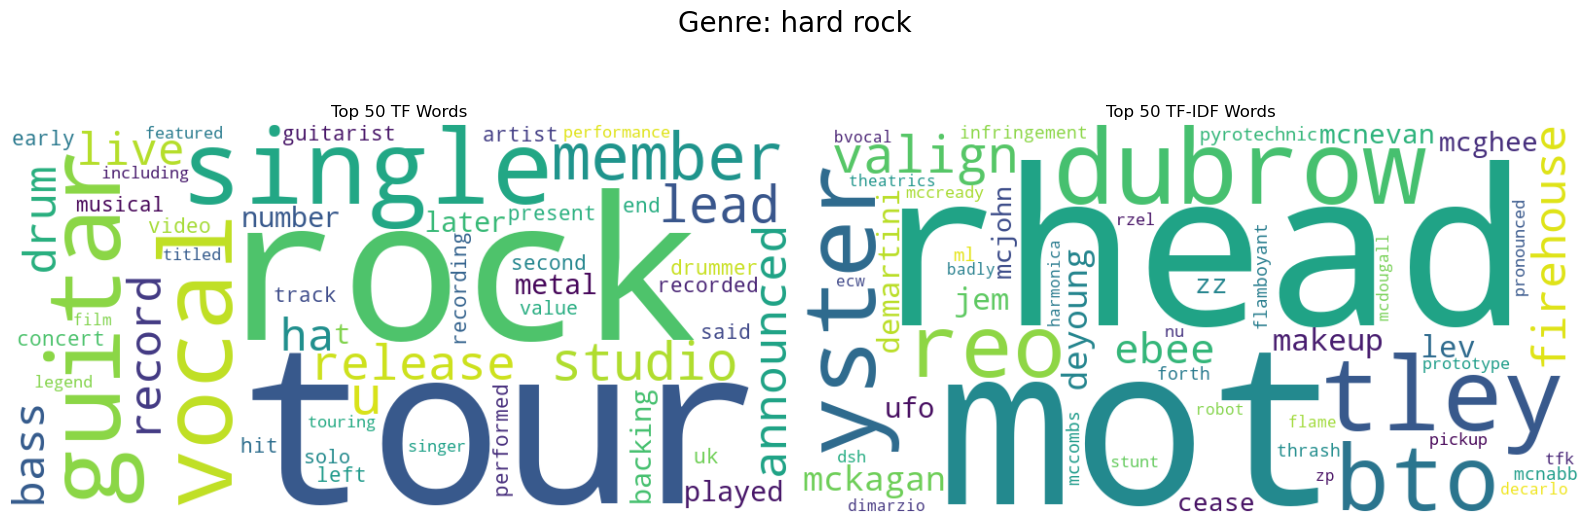

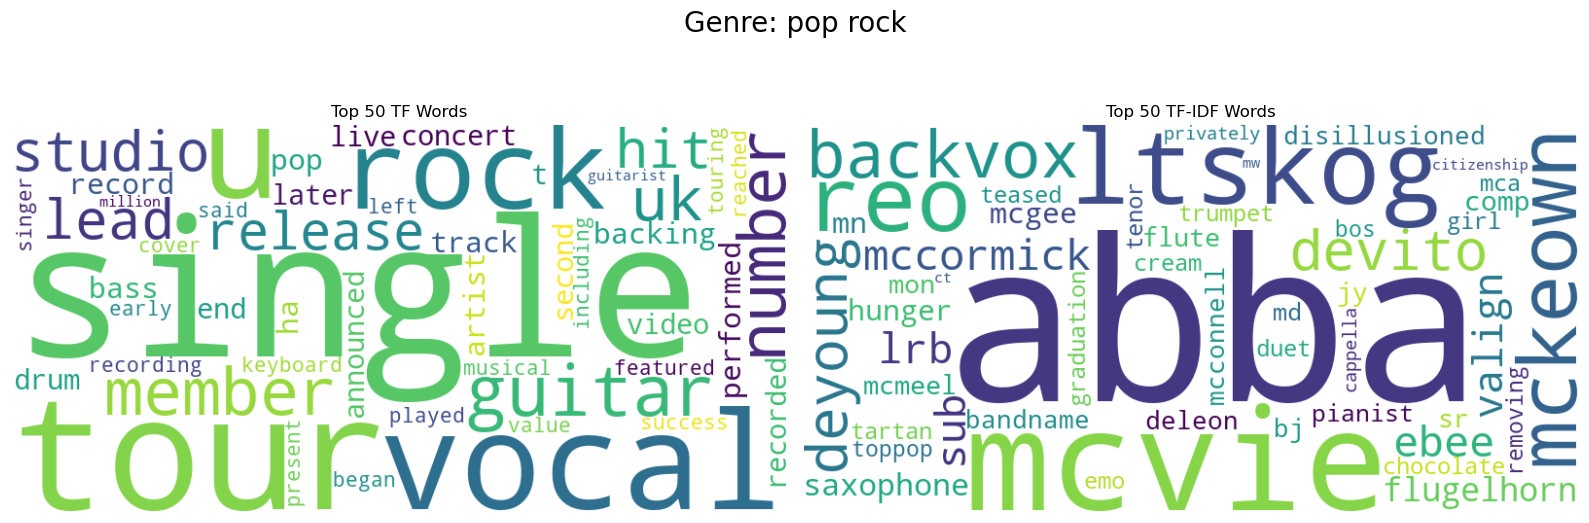

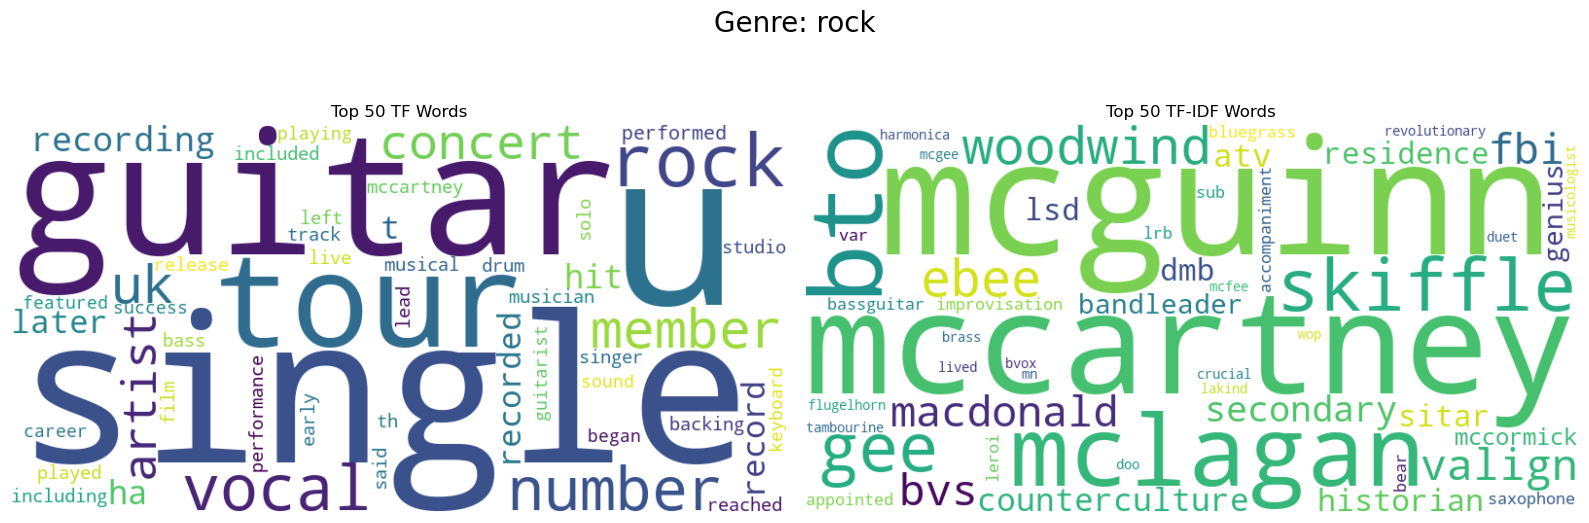

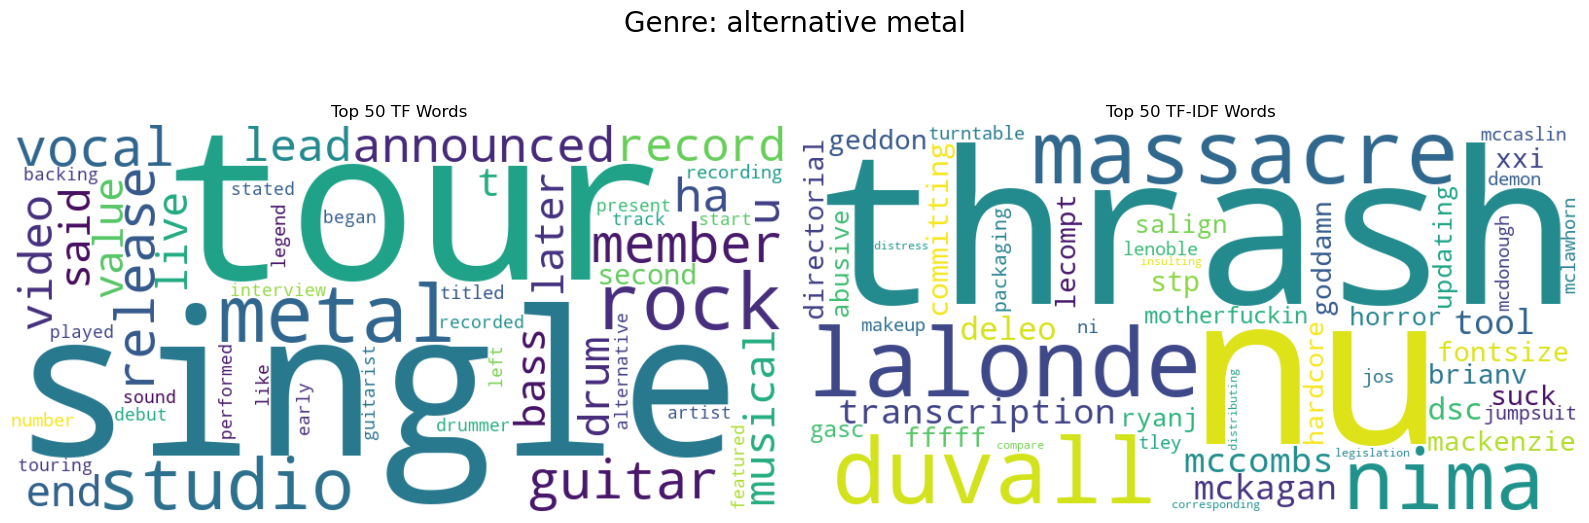

In [22]:
# create wordcloud for each genre with both TF and TF-IDF top 50 words
from wordcloud import WordCloud

for genre in top_5_genre_names:
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Set the main title for the figure to be the genre name
    fig.suptitle(f'Genre: {genre}', fontsize=20, y=0.98)
    
    # --- TF WordCloud (Left Subplot) ---
    tf_words = dict(TF_lists[genre][:50])
    wordcloud_tf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tf_words)
    
    axes[0].imshow(wordcloud_tf, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Top 50 TF Words')
    
    # --- TF-IDF WordCloud (Right Subplot) ---
    tfidf_words = dict(genre_tfidf[genre][:50])
    wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_words)
    
    axes[1].imshow(wordcloud_tfidf, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Top 50 TF-IDF Words')
    
    plt.tight_layout()
    plt.show()

The word clouds on the left (TF) are dominated by very common music-related terms such as “single”, “tour”, “rock”, “release”, and “guitar”. These words appear across almost all genres because they must be frequent in Wikipedia band pages regardless of genre. As a result, the TF-based word clouds look very similar across genres, making it hard to distinguish one genre from another.
In contrast, the word clouds on the right (TF-IDF) are much more genre-specific. Common filler words and globally frequent terms have been down-weighted by the IDF component, allowing more distinctive tokens/words to surface. For example, in the alternative rock TF-IDF cloud, we see names like “delonge”, “inxs”, “mccrea”, and terms like “shoegaze” and “hardcore”, which are strongly associated with that genre. This demonstrates that TF-IDF is better at highlighting unique identifiers for each genre.


Despite trying to clean the wiki text, some tokens in the TF-IDF clouds are still not meaningful words (e.g., abbreviations, artifacts like “dgc”, “xl”, or leftover wiki markup). This suggests that the text cleaning process could be refined further. A possible improvement could be a better scraping strategy of the wiki page.

Because each artist’s page was added to all their genres in the list, the same band text appears in multiple genres. This introduces cross-contamination, making genres look more similar than they truly are. For example, if a band belongs to both alternative rock and punk rock, its vocabulary will inflate overlap between those genres. We could have only added a band to their first genre in the list or to a randomly chosen genre in the list to reduce the effect of multi-genre duplication.

Now we can visualize the same for the communities. We have created txt files for each of the Louvain communities, where we add the band wikitext to the files, if the band belong to the community. 

Now we can as above create the TF lists for the community texts and compute the TF-IDF scores, and display the word clouds. 

In [23]:
# Create TF lists for the top 5 Louvain communities
# Assumes `top_5_communities`, `nodes_in_top_communities` and `node_to_community_idx` are available from previous cells.

TF_comm_lists={}

lemmatizer_comm = WordNetLemmatizer()

# Aggregate text for each of the communities
comm_texts = defaultdict(str)

# Read files and append text
for i, community in enumerate(top_5_communities):
    for artist in community:
        file_path = os.path.join(data_directory, f"{artist}.txt")
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    comm_texts[i] += f.read() + "\n"
            except Exception as e:
                print(f"  Could not read file {file_path}: {e}")

# Process each community document to create TF lists
for community_idx, text in comm_texts.items():

    # Use the cleaning function. (setting to lower case)
    text = clean_wikitext(text)
    
    # Tokenize and remove punctuation (find sequences of word characters)
    tokens = re.findall(r'\b[a-z]+\b', text)
    
    # Lemmatize words
    lemmatized_tokens = [lemmatizer_comm.lemmatize(token) for token in tokens]
    
    # Count word frequencies
    word_counts = Counter(lemmatized_tokens)
    
    # Filter out rare words (appearing less than 5 times) and any stop words
    frequent_word_counts = {word: count for word, count in word_counts.items() if count >= 5 and word not in stop_words}

    # Sort words by frequency in descending order
    sorted_word_counts = sorted(frequent_word_counts.items(), key=lambda item: item[1], reverse=True)
    
    # Store TF list in dictionary
    TF_comm_lists[community_idx] = sorted_word_counts

We constructed one text file per Louvain community, concatenating the Wikipedia band texts of all artists assigned to that community. Following the same pipeline as for genres, we (i) cleaned the wiki text, (ii) built term frequencies (TF) after removing punctuation, lower‑casing, lemmatizing and filtering rare tokens (≥5 occurrences) and noisy wiki artifacts.

We can now comput TF‑IDF using document frequencies at the community level (each community = one “document”). 

In [24]:
### Compute IDF
# Calculate frequency for each word across documents
document_frequency_comm = defaultdict(int)
for _, tf_list in TF_comm_lists.items():
    for word, _ in tf_list:
        document_frequency_comm[word] += 1

num_documents = len(TF_comm_lists)
idf_comm = {}
for word, df in document_frequency_comm.items():
    idf_comm[word] = compute_idf(df, num_documents, method="standard")


### Compute TF-IDF scores for each word in each community
genre_tfidf_comm = {}
for comm, tf_list in TF_comm_lists.items():
    tfidf_scores_comm = {}
    for word, tf in tf_list:
        tfidf_scores_comm[word] = tf * idf_comm.get(word, 0)
    genre_tfidf_comm[comm] = sorted(tfidf_scores_comm.items(), key=lambda x: x[1], reverse=True)



Now we can visualize the top‑50 tokens for both TF and TF‑IDF with word clouds.

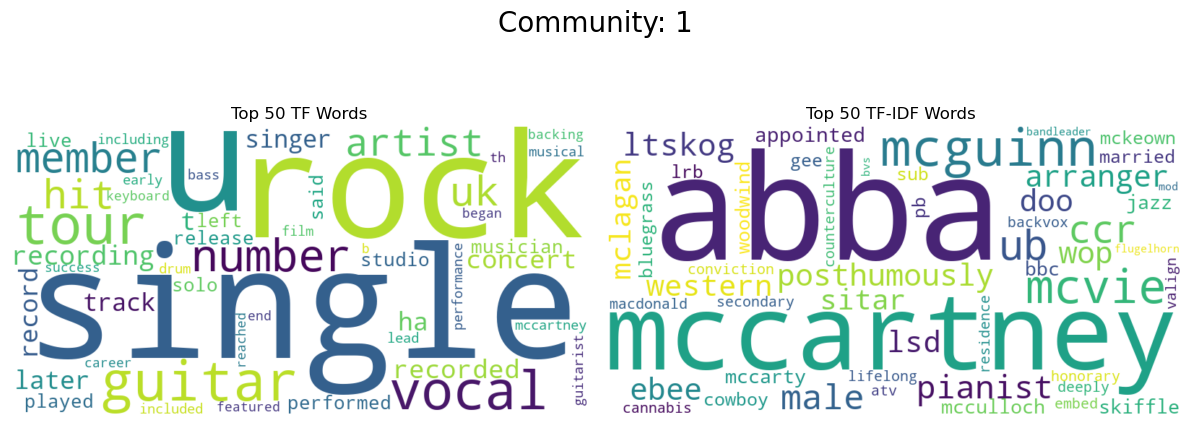

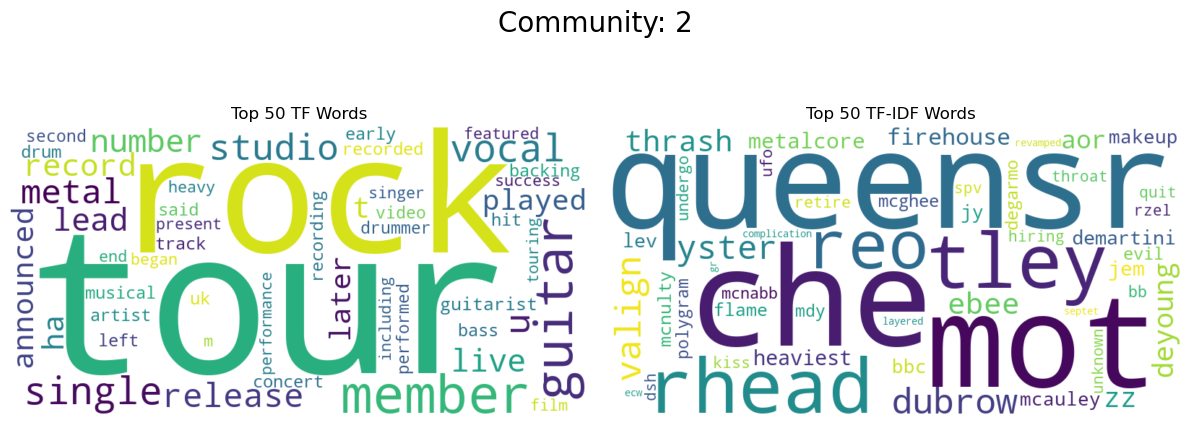

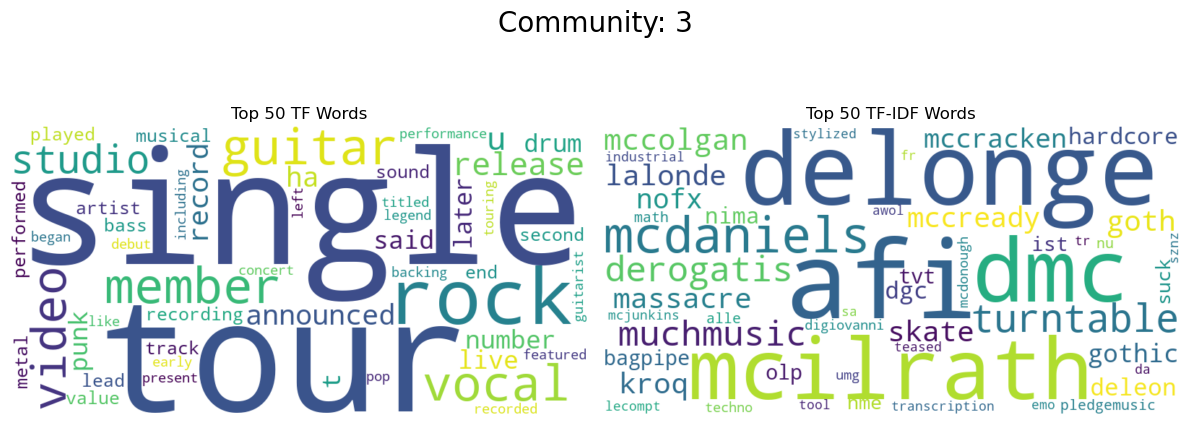

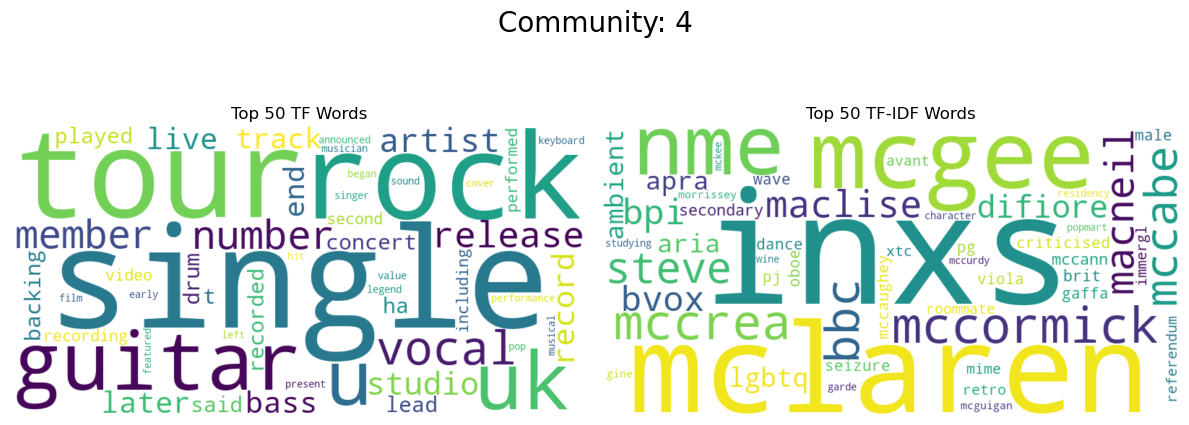

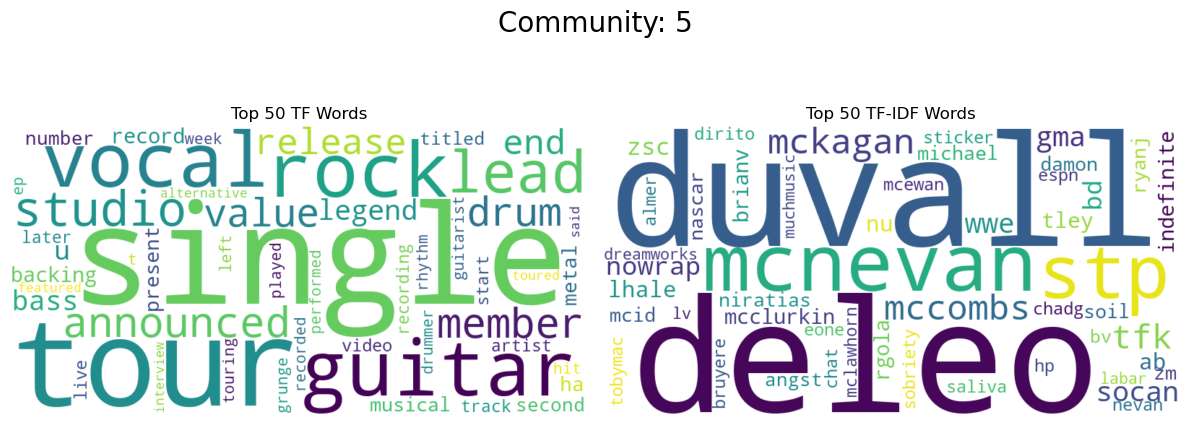

In [25]:
from wordcloud import WordCloud

for comm in range(len(TF_comm_lists)):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Set the main title for the figure to be the community name
    fig.suptitle(f'Community: {comm+1}', fontsize=20, y=0.98)
    
    # --- TF WordCloud (Left Subplot) ---
    tf_words_comm = dict(TF_comm_lists[comm][:50])
    wordcloud_tf_comm = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tf_words_comm)

    axes[0].imshow(wordcloud_tf_comm, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Top 50 TF Words')
    
    # --- TF-IDF WordCloud (Right Subplot) ---
    tfidf_words_comm = dict(genre_tfidf_comm[comm][:50])
    wordcloud_tfidf_comm = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_words_comm)

    axes[1].imshow(wordcloud_tfidf_comm, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Top 50 TF-IDF Words')
    
    plt.tight_layout()
    plt.show()

The TF word clouds for communities (Left) look very similar across all five Louvain clusters, dominated by high-frequency but low-specificity tokens, similar to teh genre clouds. This confirms that TF is not sufficient for distinguishing communities.

In contrast, the TF-IDF word clouds (right) reveal a clear pattern: they are filled with proper names, band names, record labels, etc. This is expected because the Louvain communities are network-defined, and had a higher modularity than the genres. TF-IDF makes the community-specific vocabulary much more visible.

However, some tokens are still non-informative, indicating that further cleaning and possibly better scraping (e.g., via the Wikipedia API) would improve interpretability, like we saw with the genres.


## Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

Looking at the D matrix (also plotted below), as we saw before the hard rock genre and louvain community 2 has a "strong" overlap, therefore it would be interesting to look further into the two TF-IDF wordclouds of these two, to see if they are similar.

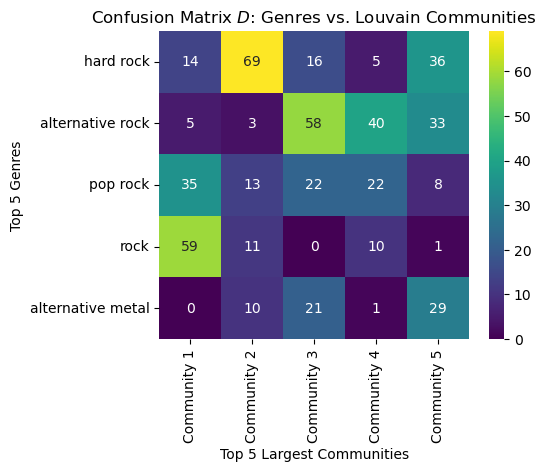

In [26]:
# Visualize D
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[f'Community {i+1}' for i in range(5)],
            yticklabels=top_5_genres)
plt.title('Confusion Matrix $D$: Genres vs. Louvain Communities')
plt.ylabel(f'Top {5} Genres')
plt.xlabel(f'Top {5} Largest Communities')
plt.show()


The confusion matrix $D$ shows the overlap between the top 5 genres and the top 5 Louvain communities based on shared bands. One cell stands out (D(1,2)): Hard Rock vs Community 2 with a count of 69, indicating a strong relationship. This actually means that Community 2 contains many nodes/bands having Hard Rock as one of their genres.
To investigate whether this structural overlap translates into word/text similarity, we would like to compare the TF-IDF word clouds for Hard Rock and Community 2. If the overlap in $D$ reflects shared vocabulary, we expect these two clouds to look similar.

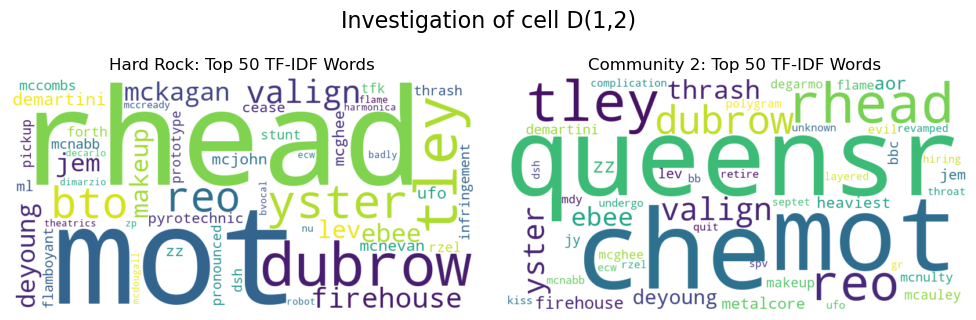

In [27]:
# Wordclouds for hard rock and community 2
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Set the main title for the figure to be the community name
fig.suptitle(f'Investigation of cell D(1,2)', fontsize=16, y=1.05)

# --- TF-IDF WordCloud 'hard rock' (Left Subplot) ---
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(genre_tfidf['hard rock'][:50]))
axes[0].imshow(wordcloud_tfidf, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Hard Rock: Top 50 TF-IDF Words')

# --- TF-IDF WordCloud 'Community 2' (Right Subplot) ---
wordcloud_tfidf_comm = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(genre_tfidf_comm[1][:50]))
axes[1].imshow(wordcloud_tfidf_comm, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Community 2: Top 50 TF-IDF Words')

plt.tight_layout()
plt.show()


The two TF-IDF word clouds (Hard Rock vs Community 2) share some tokens such as dubrow, reo, head, firehouse, and valign. Therefore we can see that there are some word overlap. Both clouds also include band names and other genre specific words associated with classic rock and metal scenes (thrash, ZZ, ufo).

However, there are also some notable differences. The Hard Rock cloud (left) emphasizes terms like pyrotechnic, prototype, and pickup, which relate to performance and musicality.
The Community 2 cloud (right) includes tokens like retire, revamped, and hiring, suggesting more biographical language.

It would be interesting to inspect pairs with low overlap in $D$ (e.g., Alternative Rock vs Community 1). These should exhibit minimal lexical similarity, but this is not done in this analysis.

While the confusion matrix $D$ shows structural overlap between genres and communities based on shared bands/nodes, it does not tell us how similar their texts/words/vocabularies are. To measure this, we compute the Jaccard overlap between the top-50 TF-IDF terms for each genre and each community. This metric is the proportion of shared distinctive words relative to the union of both sets. This provides a more nuanced view of whether high structural overlap (as seen in $D$) corresponds to high textual overlap (seen in the owrd clouds).
By visualizing these Jaccard scores in a heatmap, we can identify pairs that share many distinctive tokens (e.g., Hard Rock and Community 2). This helps us understand whether genres and communities organize language similarly or differently.

In [28]:
# Compute Jaccard overlap between top-50 TF-IDF for top-5 genres and top-5 communities
import pandas as pd
import seaborn as sns

k = 50

# Align with D: same row/col ordering
genres = top_5_genres                     # rows like D
comms = list(range(len(top_5_communities)))  # cols like D (Community 1..5)

# Safe lookups (skip if a genre wasn't TF-IDF'ed earlier)
topk_genre = {g: set([w for w, _ in genre_tfidf.get(g, [])[:k]]) for g in genres}
topk_comm  = {c: set([w for w, _ in genre_tfidf_comm[c][:k]]) for c in comms}

J = np.zeros((len(genres), len(comms)))
for i, g in enumerate(genres):
    for j, c in enumerate(comms):
        inter = len(topk_genre[g] & topk_comm[c])
        union = len(topk_genre[g] | topk_comm[c]) or 1
        J[i, j] = inter / union

plt.figure(figsize=(5, 4))
sns.heatmap(J, annot=True, fmt=".2f", cmap="magma",
            xticklabels=[f"Community {c+1}" for c in comms],
            yticklabels=genres)
plt.title("Top-50 TF-IDF Jaccard overlap (Genres vs Communities)")
plt.xlabel("Communities")
plt.ylabel("Genres")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

The Jaccard similarity heatmap quantifies the overlap between the top-50 TF-IDF terms for each genre and community. The highest value (0.32) occurs between Rock and Community 1 and by Hard Rock and Community 2 (0.32), consistent with the confusion matrix $D$, where these cells also has high frequencies. Most other pairs have very low overlap (<0.15). This means that genres and communities generally organize vocabulary differently.